# Statistical modeling for TRIBE2 PanCan 

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

## Using the best measure results
This regression analysis uses the 'best' mutations, as chosen based on the correlations previously computed.

In [2]:
data = arff.loadarff("arm0_best_mutations.arff")
arm0_best_dataset = pd.DataFrame(data[0])
data = arff.loadarff("arm1_best_mutations.arff")
arm1_best_dataset = pd.DataFrame(data[0])

### Observing the data

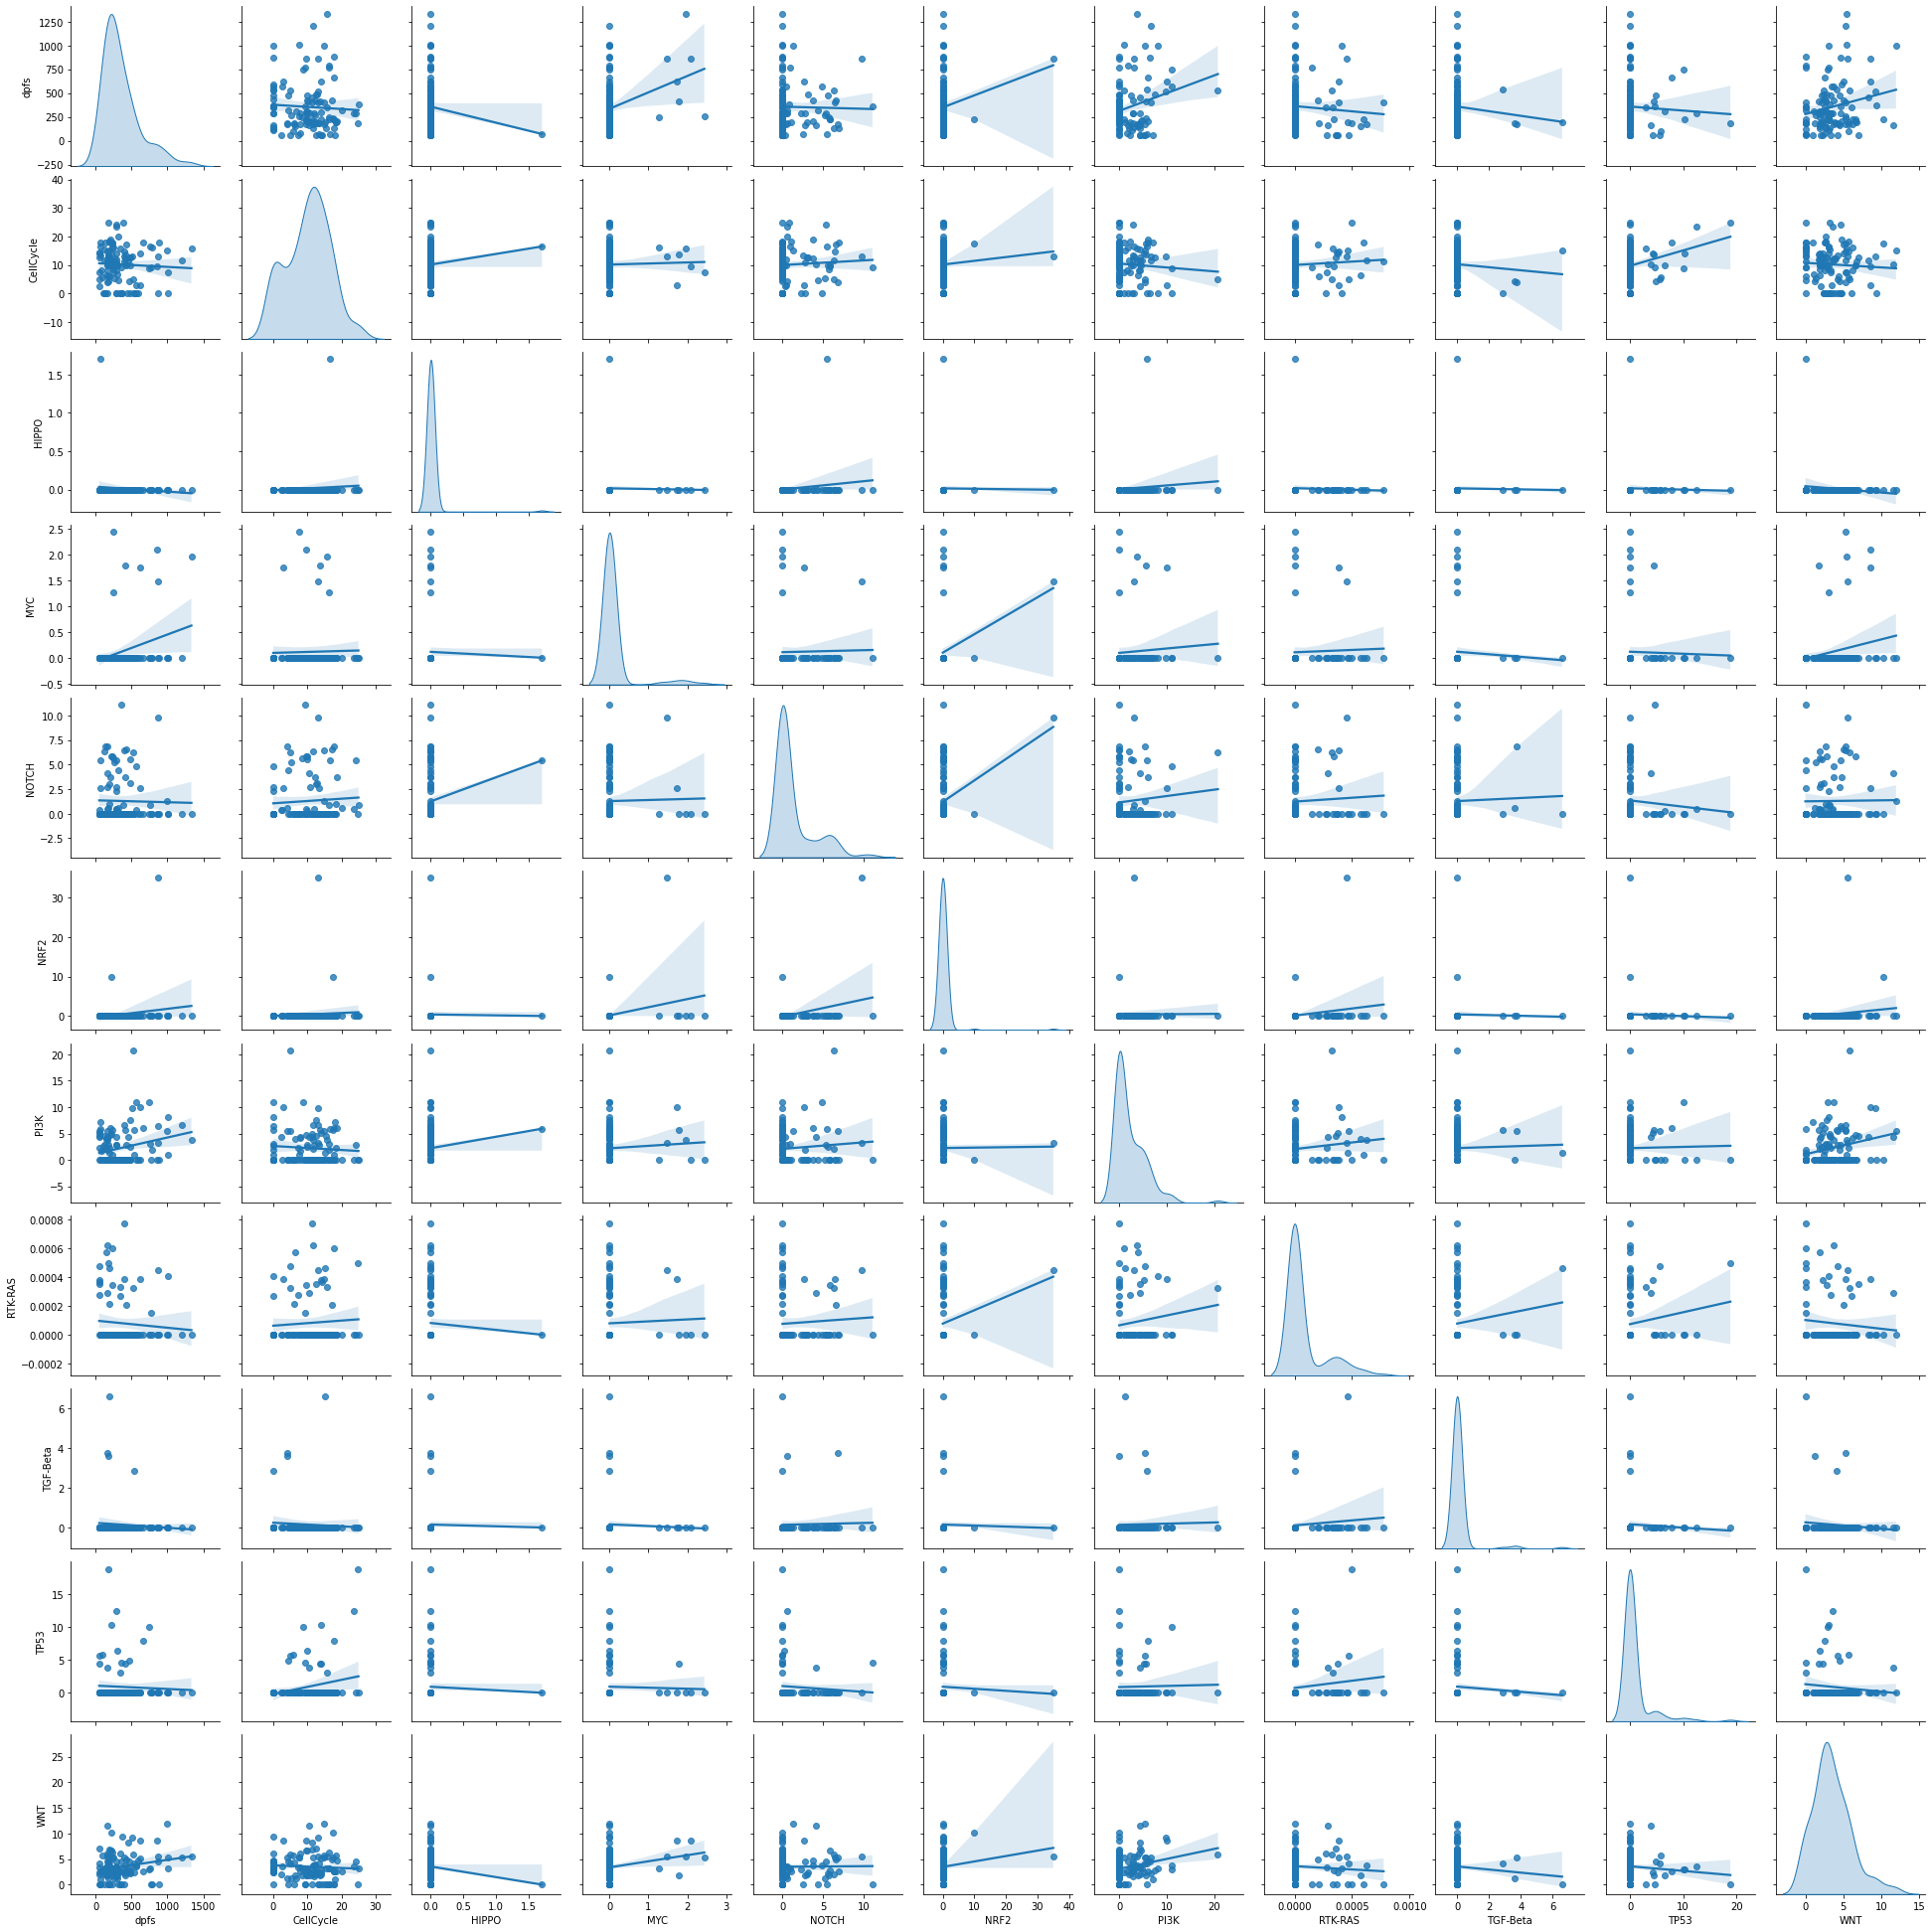

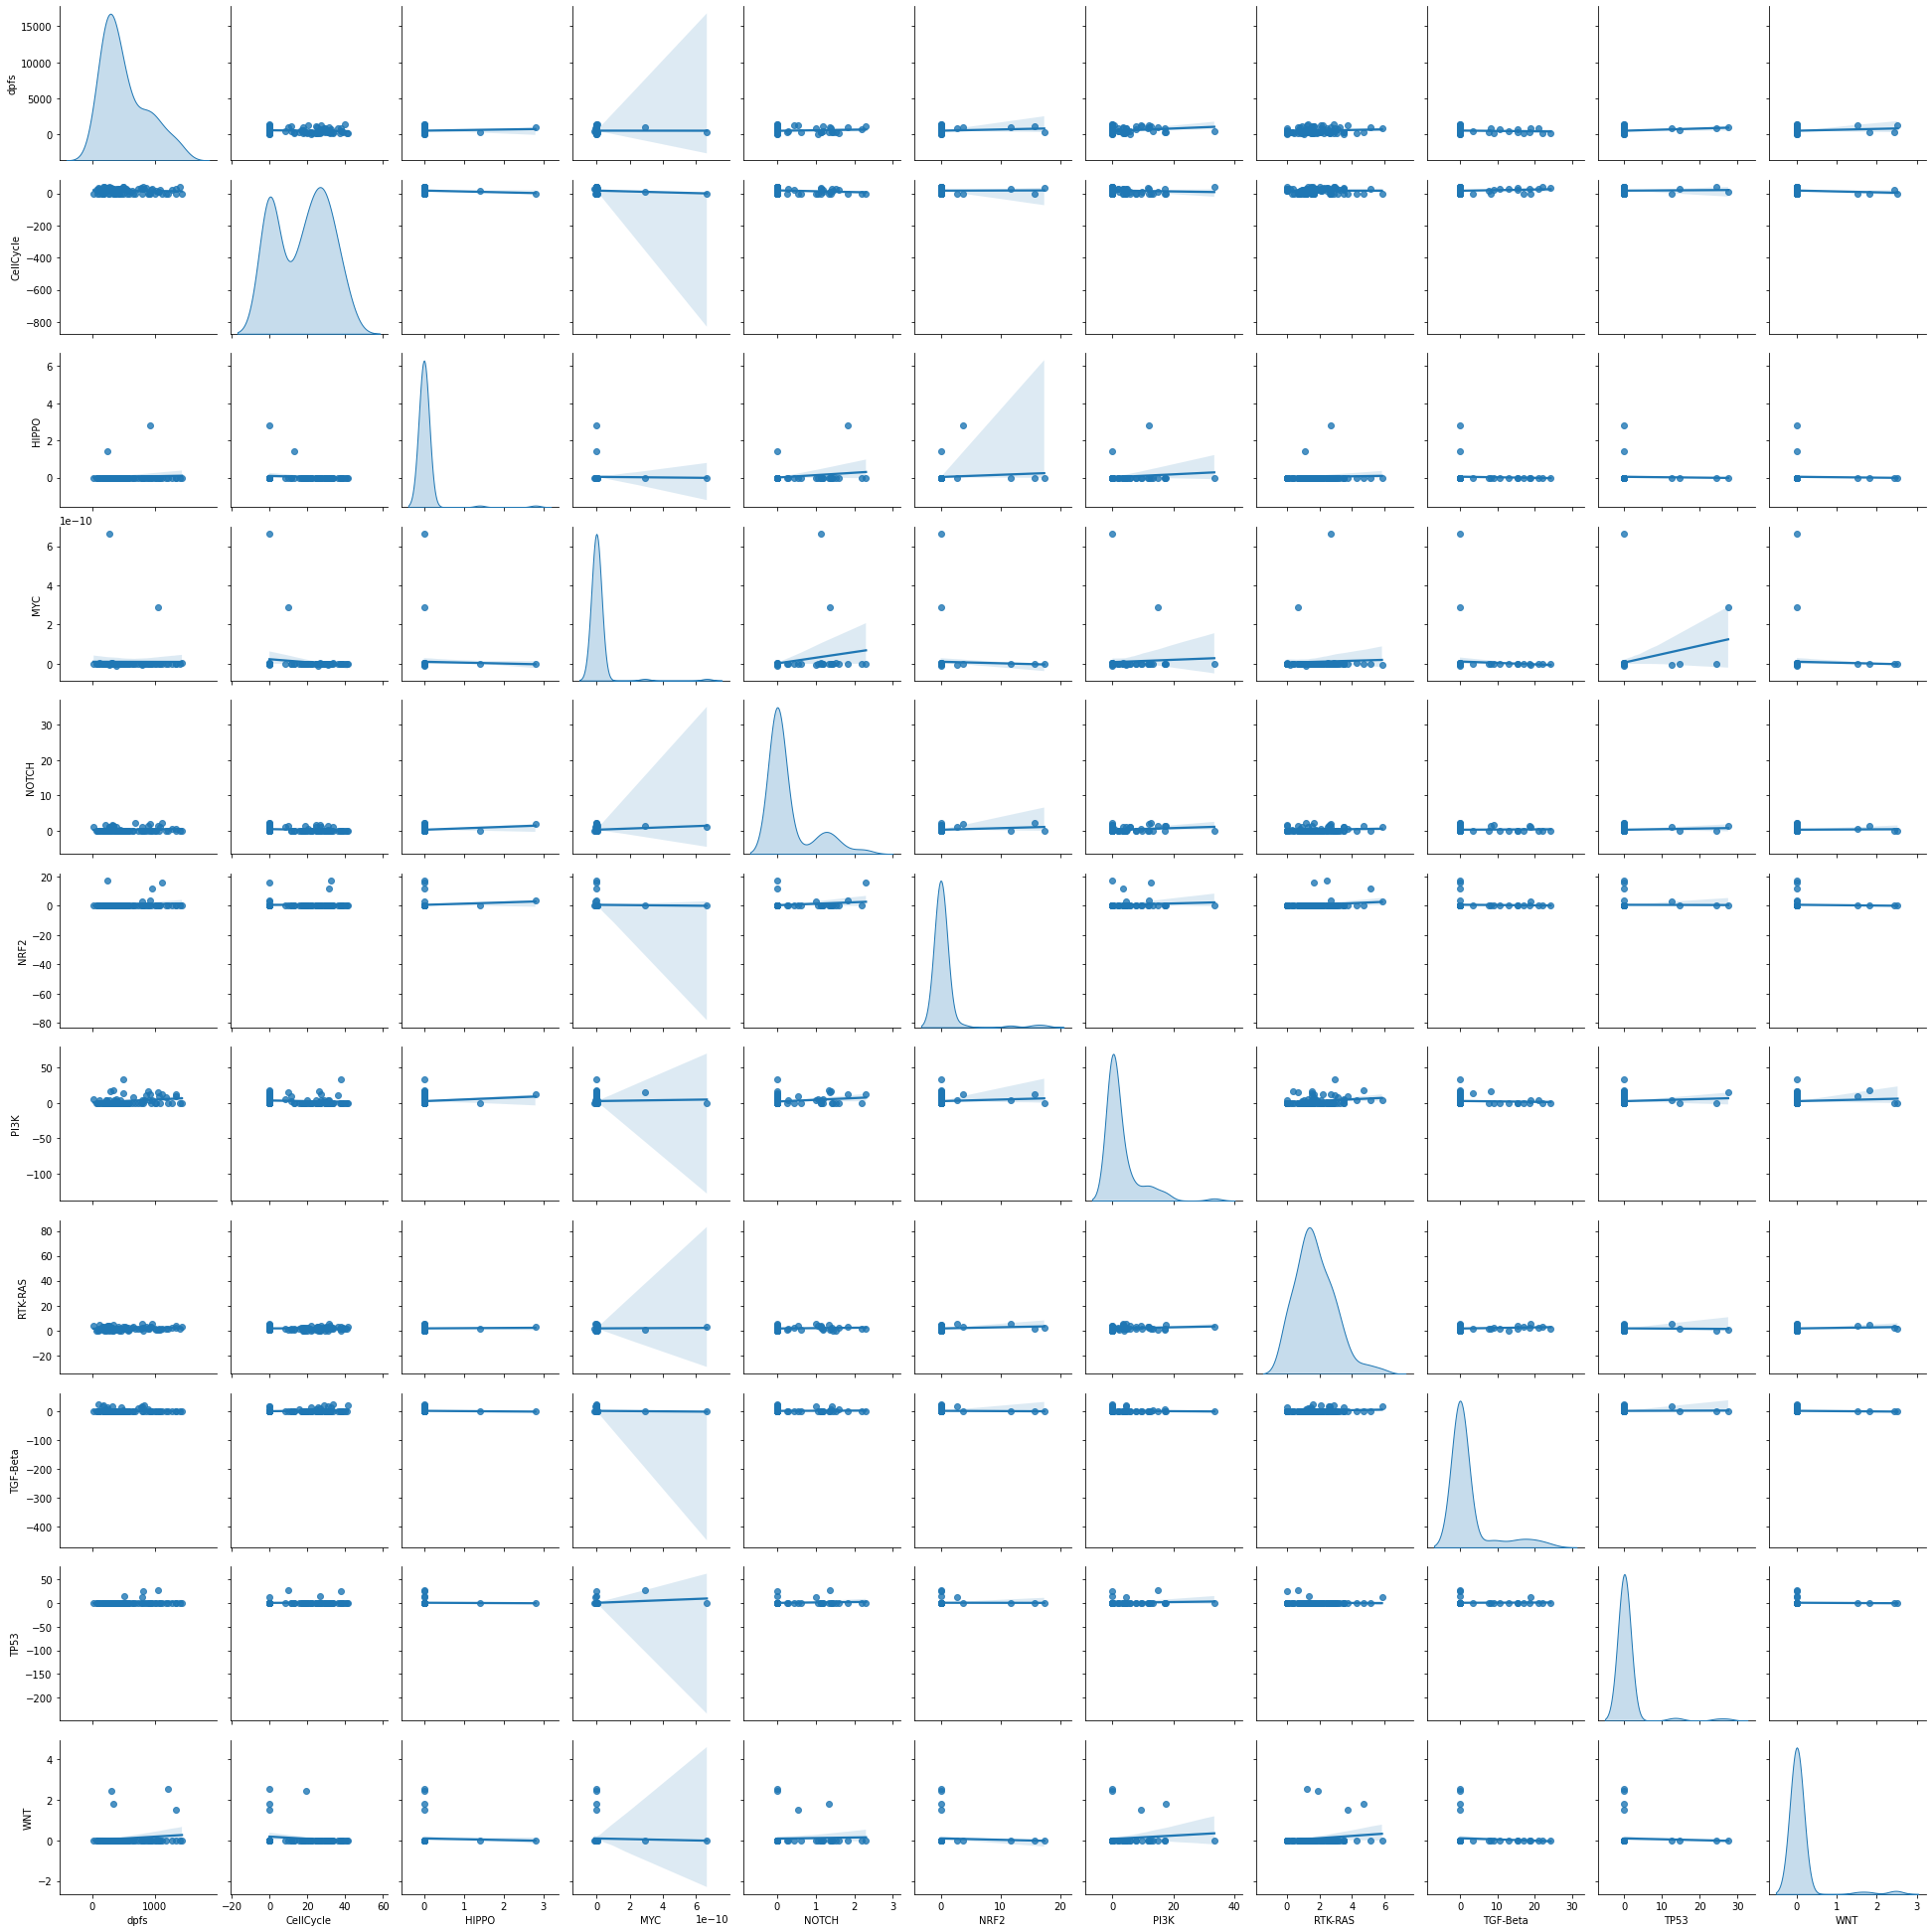

In [3]:
from sklearn.model_selection import train_test_split

arm0_x, arm0_y = (
    arm0_best_dataset.drop("dpfs", axis="columns"),
    arm0_best_dataset["dpfs"],
)
arm0_x_train, arm0_x_test, arm0_y_train, arm0_y_test = train_test_split(
    arm0_x, arm0_y, test_size=0.30, random_state=42
)
train_dataset = arm0_x_train.copy()
train_dataset.insert(0, "dpfs", arm0_y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

arm1_x, arm1_y = (
    arm1_best_dataset.drop("dpfs", axis="columns"),
    arm1_best_dataset["dpfs"],
)
arm1_x_train, arm1_x_test, arm1_y_train, arm1_y_test = train_test_split(
    arm1_x, arm1_y, test_size=0.30, random_state=42
)
train_dataset = arm1_x_train.copy()
train_dataset.insert(0, "dpfs", arm1_y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

The dpfs distribution seems to have a long tail. For this reason, it might be a good idea to take its logarithm to approximately turn it into a normal distribution.

### Linear model

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

#### arm0

In [5]:
_ = model.fit(arm0_x_train, arm0_y_train)

MAE on training set: 142.16
MAE on testing set: 199.94


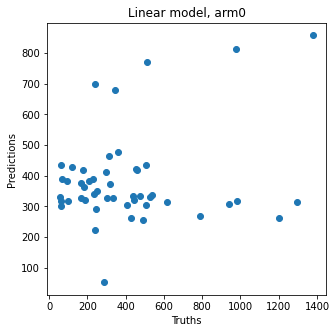

In [6]:
from sklearn.metrics import median_absolute_error

arm0_y_pred = model.predict(arm0_x_train)
mae = median_absolute_error(arm0_y_train, arm0_y_pred)
score = f"MAE on training set: {mae:.2f}"

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}"

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(arm0_y_test, arm0_y_pred)
plt.title("Linear model, arm0")
plt.ylabel("Predictions")
plt.xlabel("Truths")
print(score)
plt.show()

In [7]:
arm0_best_coefs = pd.DataFrame(
    model.coef_, columns=["Coefficients"], index=arm0_x_train.columns
)
arm0_best_coefs

,Coefficients
CellCycle,-1.047343
HIPPO,-180.957222
MYC,137.307753
NOTCH,-6.831379
NRF2,10.254035
PI3K,19.201233
RTK-RAS,-188885.835039
TGF-Beta,-17.374478
TP53,-2.209305
WNT,4.346588


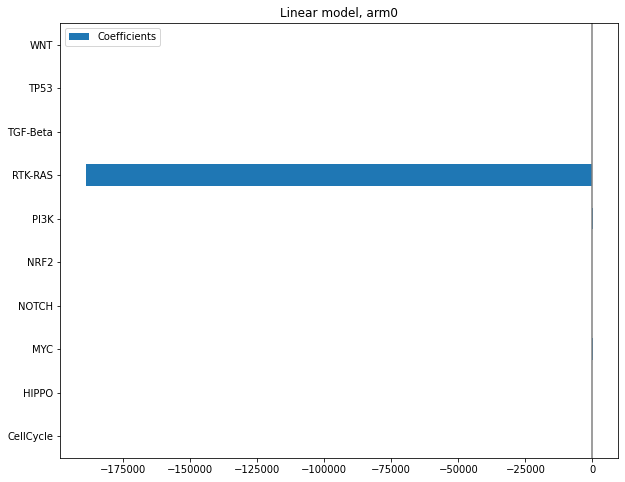

In [8]:
# fixme somehow
arm0_best_coefs.plot(kind="barh", figsize=(10, 8))
plt.title("Linear model, arm0")
plt.axvline(x=0, color=".5")

#### arm1

In [9]:
_ = model.fit(arm1_x_train, arm1_y_train)

MAE on training set: 220.90
MAE on testing set: 220.47


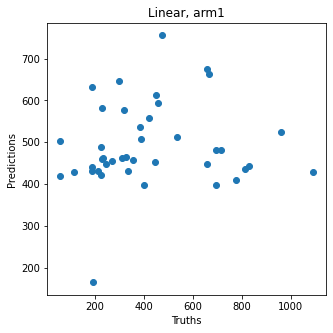

In [10]:
from sklearn.metrics import median_absolute_error

arm1_y_pred = model.predict(arm1_x_train)
mae = median_absolute_error(arm1_y_train, arm1_y_pred)
score = f"MAE on training set: {mae:.2f}"

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}"

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(arm1_y_test, arm1_y_pred)
plt.title("Linear, arm1")
plt.ylabel("Predictions")
plt.xlabel("Truths")

print(score)
plt.show()

In [11]:
arm1_best_coefs = pd.DataFrame(
    model.coef_, columns=["Coefficients"], index=arm1_x_train.columns
)
arm1_best_coefs

,Coefficients
CellCycle,-1.893271e+00
HIPPO,2.904992e+01
MYC,-3.459341e+11
NOTCH,7.696979e+00
NRF2,1.226231e+01
PI3K,1.216878e+01
RTK-RAS,2.435349e+01
TGF-Beta,-4.185675e+00
TP53,1.644856e+01
WNT,9.350219e+01


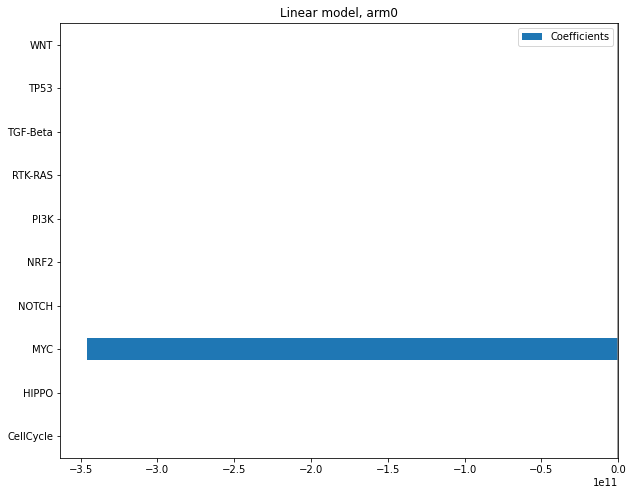

In [12]:
# fixme somehow
arm1_best_coefs.plot(kind="barh", figsize=(10, 8))
plt.title("Linear model, arm0")
plt.axvline(x=0, color=".5")

### Lasso

In [13]:
from sklearn.linear_model import LassoCV

model = LassoCV()

#### arm0

In [14]:
_ = model.fit(arm0_x_train, arm0_y_train)

MAE on training set: 155.22
MAE on testing set: 154.22


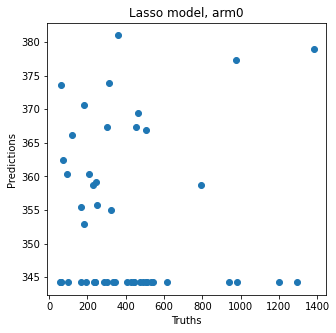

In [15]:
from sklearn.metrics import median_absolute_error

arm0_y_pred = model.predict(arm0_x_train)
mae = median_absolute_error(arm0_y_train, arm0_y_pred)
score = f"MAE on training set: {mae:.2f}"

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}"

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(arm0_y_test, arm0_y_pred)
plt.title("Lasso model, arm0")
plt.ylabel("Predictions")
plt.xlabel("Truths")
print(score)
plt.show()

In [16]:
arm0_best_coefs = pd.DataFrame(
    model.coef_, columns=["Coefficients"], index=arm0_x_train.columns
)
arm0_best_coefs

,Coefficients
CellCycle,-0.000000
HIPPO,-0.000000
MYC,0.000000
NOTCH,-0.000000
NRF2,0.000000
PI3K,4.546551
RTK-RAS,-0.000000
TGF-Beta,-0.000000
TP53,-0.000000
WNT,0.000000


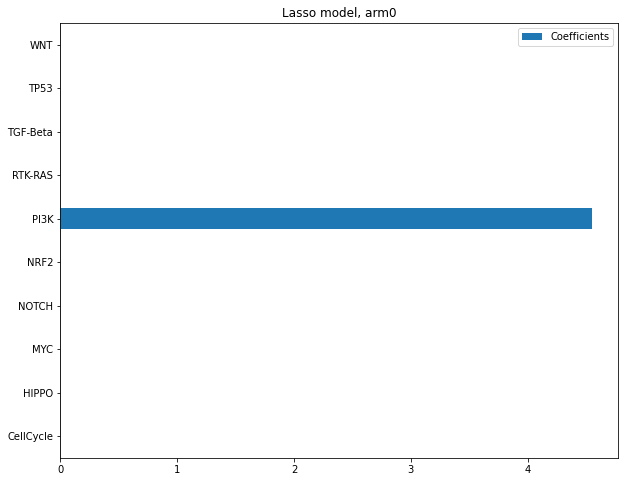

In [17]:
# fixme somehow
arm0_best_coefs.plot(kind="barh", figsize=(10, 8))
plt.title("Lasso model, arm0")
plt.axvline(x=0, color=".5")

#### arm1

In [18]:
_ = model.fit(arm1_x_train, arm1_y_train)

MAE on training set: 251.38
MAE on testing set: 219.78


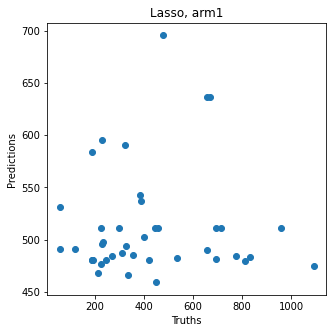

In [19]:
from sklearn.metrics import median_absolute_error

arm1_y_pred = model.predict(arm1_x_train)
mae = median_absolute_error(arm1_y_train, arm1_y_pred)
score = f"MAE on training set: {mae:.2f}"

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}"

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(arm1_y_test, arm1_y_pred)
plt.title("Lasso, arm1")
plt.ylabel("Predictions")
plt.xlabel("Truths")

print(score)
plt.show()

In [20]:
arm1_best_coefs = pd.DataFrame(
    model.coef_, columns=["Coefficients"], index=arm1_x_train.columns
)
arm1_best_coefs

,Coefficients
CellCycle,-1.247079
HIPPO,0.000000
MYC,-0.000000
NOTCH,0.000000
NRF2,0.000000
PI3K,8.934564
RTK-RAS,0.000000
TGF-Beta,-0.000000
TP53,0.678723
WNT,0.000000


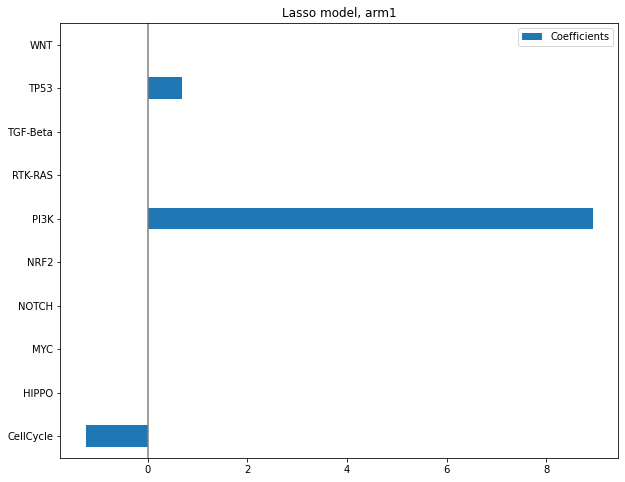

In [21]:
# fixme somehow
arm1_best_coefs.plot(kind="barh", figsize=(10, 8))
plt.title("Lasso model, arm1")
plt.axvline(x=0, color=".5")

## Using all mutation measures